## Import Libraries

In [1]:
import os
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()
import math
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

### A. Load the data

In [2]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [3]:
train_df = load_data('train', columns='full')

select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split


## 2. Preprocessing

Preprocessing and feature engineering is important in machine learning

In [7]:
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [8]:
train_df = load_data('train', columns='full')
valid_df = load_data('valid', columns='full')


train_ids = train_df['review_id']
train_texts = train_df['text']
train_labels = train_df['stars']

test_ids = valid_df['review_id']
test_texts = valid_df['text']
test_labels = valid_df['stars']




# extract features
train_tokens = [tokenize(text) for text in train_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]

# build the feature list
train_feats = list()
for i in range(len(train_ids)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
test_feats = list()
for i in range(len(test_ids)):
    test_feats.append(
        test_stemmed[i] + test_2_gram[i] + test_3_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split
select [f, u, l, l] columns from the valid split
Failed, then try to 
select all columns from the valid split
Size of features: 39838


stemmed feature size: 24119


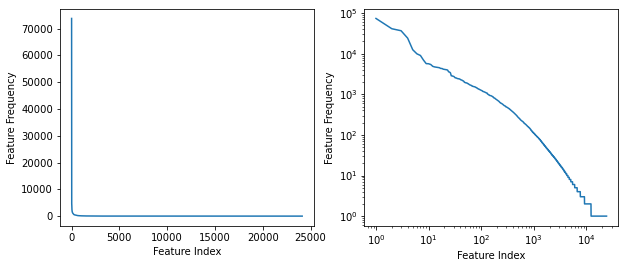

In [9]:
# first, build a Counter for stemmed features, e.g., {"text": 2, "mine": 1}
stemmed_feat_cnt = Counter()
for feats in train_stemmed:
    stemmed_feat_cnt.update(feats)
print("stemmed feature size:", len(stemmed_feat_cnt))

# then, get the sorted features by the frequency
stemmed_feat_keys = [f for f, cnt in stemmed_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
# set the figure size
plt.figure(figsize=(10,4))
# generate two subfigures and set current as the first one
plt.subplot(1,2,1)
# draw linear lines
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys])
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# set current as the second one
plt.subplot(1,2,2)
# draw log lines
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
           [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10)
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

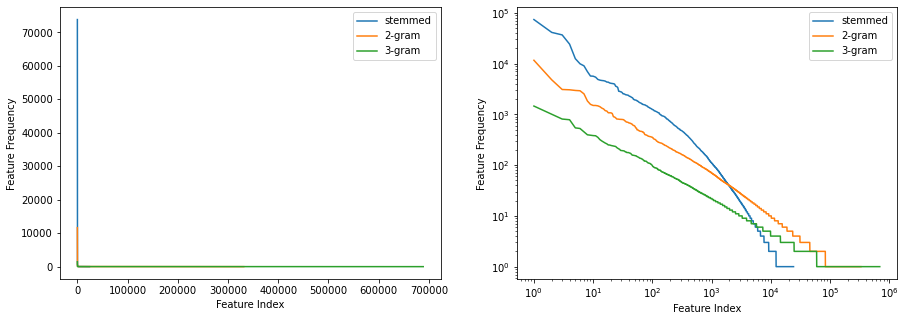

stemmed feature size: 24119
2-gram feature size: 331339
3-gram feature size: 688795


In [10]:
# build Counters for 2-gram features and 3-gram features
bi_gram_feat_cnt = Counter()
for feats in train_2_gram:
    bi_gram_feat_cnt.update(feats)
    
tri_gram_feat_cnt = Counter()
for feats in train_3_gram:
    tri_gram_feat_cnt.update(feats)

# then, get the sorted features by the frequency
bi_gram_feat_keys = [f for f, cnt in bi_gram_feat_cnt.most_common()]
tri_gram_feat_keys = [f for f,cnt in tri_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# put the four linear lines together
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
         label="stemmed")
plt.plot(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
         label="2-gram")
plt.plot(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
         label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.subplot(1,2,2)
# put the four log lines together
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10, label="stemmed")
plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
           basex=10, basey=10, label="2-gram")
plt.loglog(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10, label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.show()

print("stemmed feature size:", len(stemmed_feat_cnt))
print("2-gram feature size:", len(bi_gram_feat_cnt))
print("3-gram feature size:", len(tri_gram_feat_cnt))



In [11]:
print("stemmed features > 10:",
      len([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]))
print("2-gram features > 10:",
      len([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]))
print("3-gram features > 10:",
      len([f for f, cnt in tri_gram_feat_cnt.items() if cnt > 10]))

stemmed features > 10: 4217
2-gram features > 10: 9173
3-gram features > 10: 2870


In [12]:
print("stemmed features top 10:",
      stemmed_feat_keys[:10])
print("2-gram features top 10:",
      bi_gram_feat_keys[:10])
print("3-gram features top 10:",
      tri_gram_feat_keys[:10])

stemmed features top 10: ['.', ',', 'I', 'wa', '!', 'thi', "n't", "'s", 'food', 'place']
2-gram features top 10: ['. I', ', I', '! !', '. We', '. It', 'I wa', 'thi place', "I 'm", 'I would', "I n't"]
3-gram features top 10: ['! ! !', '. It wa', ". It 's", '. I wa', ". I 'm", '. I would', ". I n't", 'thi place .', ', I wa', ". I 've"]


## 1-layer perceptron

In [13]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier(input_size, output_size,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     learning_rate=0.1,
                     metric="accuracy"):

    model = Sequential()
    
    # the projection layer
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "Adadelta'":
        optmizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == "Adagrad":
        optmizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == "Adamax":
        optmizer = keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer == "Nadam":
        optmizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    return model

In [16]:
def create_model(optimizer='SGD', lr = 0.1):
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes,optimizer=optimizer, learning_rate=lr)
    return model

np.random.seed(0)
tf.random.set_seed(0)

#create the model with the best epoch and batch size found in last step
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=5, verbose=0)

# difine grid search parameter 
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
            ]
lr = [0.01,0.1, 0.5]
batch_size = [5, 20,50]
epochs = [2, 5, 10]
param_grid = dict(optimizer=optimizer, 
                  lr=lr,
                  batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid,verbose=70,cv=2)
grid_result = grid.fit(train_feats_matrix, train_label_matrix,)

# grid searching result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 189 candidates, totalling 378 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=SGD ..................
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=SGD, score=0.563, total=   5.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=SGD ..................
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=SGD, score=0.558, total=   6.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=RMSprop ..............
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=RMSprop, score=0.585, total=   4.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=RMSprop ..............
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=RMSprop, score=0.584, total=   6.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 157, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipython-input-16-177f3648638c>", line 2, in create_model
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes,optimizer=optimizer, lea

[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=Adadelta, score=nan, total=   0.8s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.6s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=Adadelta .............
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=Adadelta, score=nan, total=   0.8s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   40.5s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=Adam .................
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=Adam, score=0.586, total=  10.1s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   50.9s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=Adam .................
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=Adam, score=0.584, total=   5.7s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   56.8s remaining:    0.0s
[CV] batch_size=5, epochs=2, lr=0.01, optimizer=Adamax ...............
[CV]  batch_size=5, epochs=2, lr=0.01, optimizer=Adamax, score=0

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  4.0min remaining:    0.0s
[CV] batch_size=5, epochs=5, lr=0.01, optimizer=SGD ..................
[CV]  batch_size=5, epochs=5, lr=0.01, optimizer=SGD, score=0.576, total=   6.1s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  4.1min remaining:    0.0s
[CV] batch_size=5, epochs=5, lr=0.01, optimizer=SGD ..................
[CV]  batch_size=5, epochs=5, lr=0.01, optimizer=SGD, score=0.574, total=   6.6s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  4.3min remaining:    0.0s
[CV] batch_size=5, epochs=5, lr=0.01, optimizer=RMSprop ..............
[CV]  batch_size=5, epochs=5, lr=0.01, optimizer=RMSprop, score=0.586, total=  11.5s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.5min remaining:    0.0s
[CV] batch_size=5, epochs=5, lr=0.01, optimizer=RMSprop ..............
[CV]  batch_size=5, epochs=5, lr=0.01, optimizer=RMSprop, score=0.590, total=   7.4s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  4.6min rem

[CV] batch_size=5, epochs=5, lr=0.5, optimizer=Adamax ................
[CV]  batch_size=5, epochs=5, lr=0.5, optimizer=Adamax, score=0.586, total=   7.7s
[CV] batch_size=5, epochs=5, lr=0.5, optimizer=Nadam .................
[CV]  batch_size=5, epochs=5, lr=0.5, optimizer=Nadam, score=0.585, total=  13.4s
[CV] batch_size=5, epochs=5, lr=0.5, optimizer=Nadam .................
[CV]  batch_size=5, epochs=5, lr=0.5, optimizer=Nadam, score=0.572, total=  10.7s
[CV] batch_size=5, epochs=10, lr=0.01, optimizer=SGD .................
[CV]  batch_size=5, epochs=10, lr=0.01, optimizer=SGD, score=0.580, total=   9.1s
[CV] batch_size=5, epochs=10, lr=0.01, optimizer=SGD .................
[CV]  batch_size=5, epochs=10, lr=0.01, optimizer=SGD, score=0.573, total=   9.4s
[CV] batch_size=5, epochs=10, lr=0.01, optimizer=RMSprop .............
[CV]  batch_size=5, epochs=10, lr=0.01, optimizer=RMSprop, score=0.579, total=  13.1s
[CV] batch_size=5, epochs=10, lr=0.01, optimizer=RMSprop .............
[CV]  

[CV]  batch_size=20, epochs=2, lr=0.01, optimizer=Adam, score=0.587, total=   3.4s
[CV] batch_size=20, epochs=2, lr=0.01, optimizer=Adam ................
[CV]  batch_size=20, epochs=2, lr=0.01, optimizer=Adam, score=0.588, total=   3.6s
[CV] batch_size=20, epochs=2, lr=0.01, optimizer=Adamax ..............
[CV]  batch_size=20, epochs=2, lr=0.01, optimizer=Adamax, score=0.558, total=   4.9s
[CV] batch_size=20, epochs=2, lr=0.01, optimizer=Adamax ..............
[CV]  batch_size=20, epochs=2, lr=0.01, optimizer=Adamax, score=0.562, total=   4.9s
[CV] batch_size=20, epochs=2, lr=0.01, optimizer=Nadam ...............
[CV]  batch_size=20, epochs=2, lr=0.01, optimizer=Nadam, score=0.586, total=   9.0s
[CV] batch_size=20, epochs=2, lr=0.01, optimizer=Nadam ...............
[CV]  batch_size=20, epochs=2, lr=0.01, optimizer=Nadam, score=0.580, total=   4.0s
[CV] batch_size=20, epochs=2, lr=0.1, optimizer=SGD ..................
[CV]  batch_size=20, epochs=2, lr=0.1, optimizer=SGD, score=0.575, tot

[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adagrad, score=0.462, total=   5.3s
[CV] batch_size=20, epochs=5, lr=0.1, optimizer=Adadelta .............
[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adadelta, score=nan, total=   0.8s
[CV] batch_size=20, epochs=5, lr=0.1, optimizer=Adadelta .............
[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adadelta, score=nan, total=   0.7s
[CV] batch_size=20, epochs=5, lr=0.1, optimizer=Adam .................
[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adam, score=0.590, total=   5.5s
[CV] batch_size=20, epochs=5, lr=0.1, optimizer=Adam .................
[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adam, score=0.584, total=   7.9s
[CV] batch_size=20, epochs=5, lr=0.1, optimizer=Adamax ...............
[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adamax, score=0.581, total=  14.5s
[CV] batch_size=20, epochs=5, lr=0.1, optimizer=Adamax ...............
[CV]  batch_size=20, epochs=5, lr=0.1, optimizer=Adamax, score=0.580, tot

[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=RMSprop, score=0.586, total=  23.1s
[CV] batch_size=20, epochs=10, lr=0.5, optimizer=Adagrad .............
[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=Adagrad, score=0.528, total=   8.7s
[CV] batch_size=20, epochs=10, lr=0.5, optimizer=Adagrad .............
[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=Adagrad, score=0.517, total=   8.9s
[CV] batch_size=20, epochs=10, lr=0.5, optimizer=Adadelta ............
[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=Adadelta, score=nan, total=   0.8s
[CV] batch_size=20, epochs=10, lr=0.5, optimizer=Adadelta ............
[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=Adadelta, score=nan, total=   0.7s
[CV] batch_size=20, epochs=10, lr=0.5, optimizer=Adam ................
[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=Adam, score=0.586, total=  12.1s
[CV] batch_size=20, epochs=10, lr=0.5, optimizer=Adam ................
[CV]  batch_size=20, epochs=10, lr=0.5, optimizer=Adam, score=0

[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=SGD, score=0.522, total=   4.7s
[CV] batch_size=50, epochs=5, lr=0.01, optimizer=SGD .................
[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=SGD, score=0.525, total=   8.2s
[CV] batch_size=50, epochs=5, lr=0.01, optimizer=RMSprop .............
[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=RMSprop, score=0.586, total=   8.6s
[CV] batch_size=50, epochs=5, lr=0.01, optimizer=RMSprop .............
[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=RMSprop, score=0.590, total=  10.4s
[CV] batch_size=50, epochs=5, lr=0.01, optimizer=Adagrad .............
[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=Adagrad, score=0.440, total=   4.9s
[CV] batch_size=50, epochs=5, lr=0.01, optimizer=Adagrad .............
[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=Adagrad, score=0.416, total=   4.7s
[CV] batch_size=50, epochs=5, lr=0.01, optimizer=Adadelta ............
[CV]  batch_size=50, epochs=5, lr=0.01, optimizer=Adadelta, score=

[CV]  batch_size=50, epochs=10, lr=0.01, optimizer=Adamax, score=0.585, total=   9.9s
[CV] batch_size=50, epochs=10, lr=0.01, optimizer=Nadam ..............
[CV]  batch_size=50, epochs=10, lr=0.01, optimizer=Nadam, score=0.587, total=  13.4s
[CV] batch_size=50, epochs=10, lr=0.01, optimizer=Nadam ..............
[CV]  batch_size=50, epochs=10, lr=0.01, optimizer=Nadam, score=0.581, total=   8.7s
[CV] batch_size=50, epochs=10, lr=0.1, optimizer=SGD .................
[CV]  batch_size=50, epochs=10, lr=0.1, optimizer=SGD, score=0.580, total=   7.4s
[CV] batch_size=50, epochs=10, lr=0.1, optimizer=SGD .................
[CV]  batch_size=50, epochs=10, lr=0.1, optimizer=SGD, score=0.572, total=   7.7s
[CV] batch_size=50, epochs=10, lr=0.1, optimizer=RMSprop .............
[CV]  batch_size=50, epochs=10, lr=0.1, optimizer=RMSprop, score=0.589, total=  10.7s
[CV] batch_size=50, epochs=10, lr=0.1, optimizer=RMSprop .............
[CV]  batch_size=50, epochs=10, lr=0.1, optimizer=RMSprop, score=0.5

###  The best SLP model is
### 'batch_size': 20, 'epochs': 5, 'lr': 0.5, 'optimizer': 'RMSprop'
### The accuracy is 0.5909